<a href="https://colab.research.google.com/github/IaraSelva/machine_learning/blob/main/Medium02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [10]:
# Read data
file = 'drive/My Drive/machine_learning/Transactions.csv'
df = pd.read_csv(file)

df.head()

,Unnamed: 0.1,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO
0,0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,Legitimate Transaction
1,1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,Legitimate Transaction
2,2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,Fraudulent Transaction Internet
3,3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,Legitimate Transaction
4,4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,Legitimate Transaction


In [7]:
# Data exploration
n_rows = df.shape[0]
n_columns = df.shape[1]
print(f'n_rows = {n_rows}\nn_columns = {n_columns}\n')

column_names = df.columns.tolist()
print(f'column_names: {column_names}\n')

df.isnull().sum()


n_rows = 1754155
n_columns = 10

column_names: ['Unnamed: 0.1', 'Unnamed: 0', 'TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD_SCENARIO']



Unnamed: 0.1         0
Unnamed: 0           0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD_SCENARIO    0
dtype: int64

In [11]:
df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO
0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,Legitimate Transaction
1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,Legitimate Transaction
2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,Fraudulent Transaction Internet
3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,Legitimate Transaction
4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,Legitimate Transaction


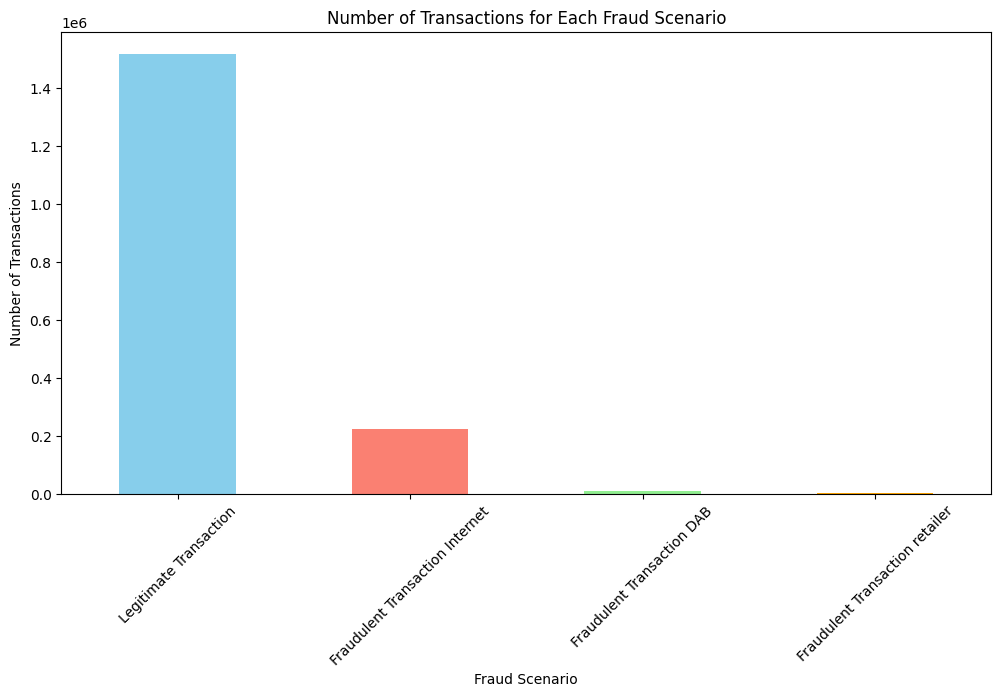

In [12]:
def plot_fraud_scenario_counts(data_frame):
    """
    Plots the counts of transactions for different fraud scenarios.

    :param data_frame: The DataFrame containing the data.
    """
    fraud_scenario_counts = data_frame['TX_FRAUD_SCENARIO'].value_counts()

    plt.figure(figsize=(12, 6))
    fraud_scenario_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral'])
    plt.title('Number of Transactions for Each Fraud Scenario')
    plt.xlabel('Fraud Scenario')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)

    plt.show()


# Call the function to plot fraud scenario counts
plot_fraud_scenario_counts(df)

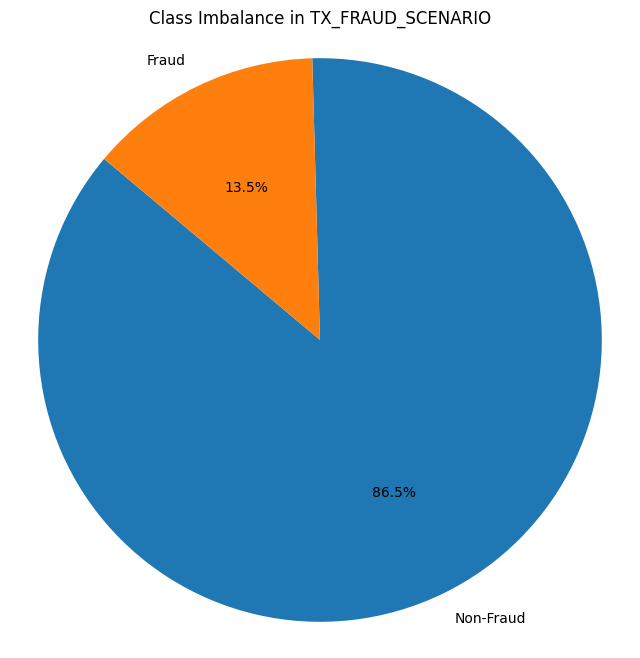

In [13]:
def plot_data_imbalance(data_frame, target_column):
    """
    Display a pie chart to illustrate class imbalance in the target column.

    :param data_frame: The DataFrame containing the data.
    :param target_column: The name of the target column for which the imbalance should be illustrated.
    """
    class_counts = data_frame[target_column].value_counts()

    # Merge all fraud scenarios into a single category
    data_frame['FRAUD'] = data_frame[target_column].apply(lambda x: 'Fraud' if 'Fraudulent' in x else 'Non-Fraud')

    # Count the occurrences of each class in the merged column
    class_counts = data_frame['FRAUD'].value_counts()

    # Plot the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Class Imbalance in {}'.format(target_column))
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()


# Call the function to display class imbalance in the 'TX_FRAUD_SCENARIO' column
plot_data_imbalance(df, 'TX_FRAUD_SCENARIO')
# Think about merging your frauds together

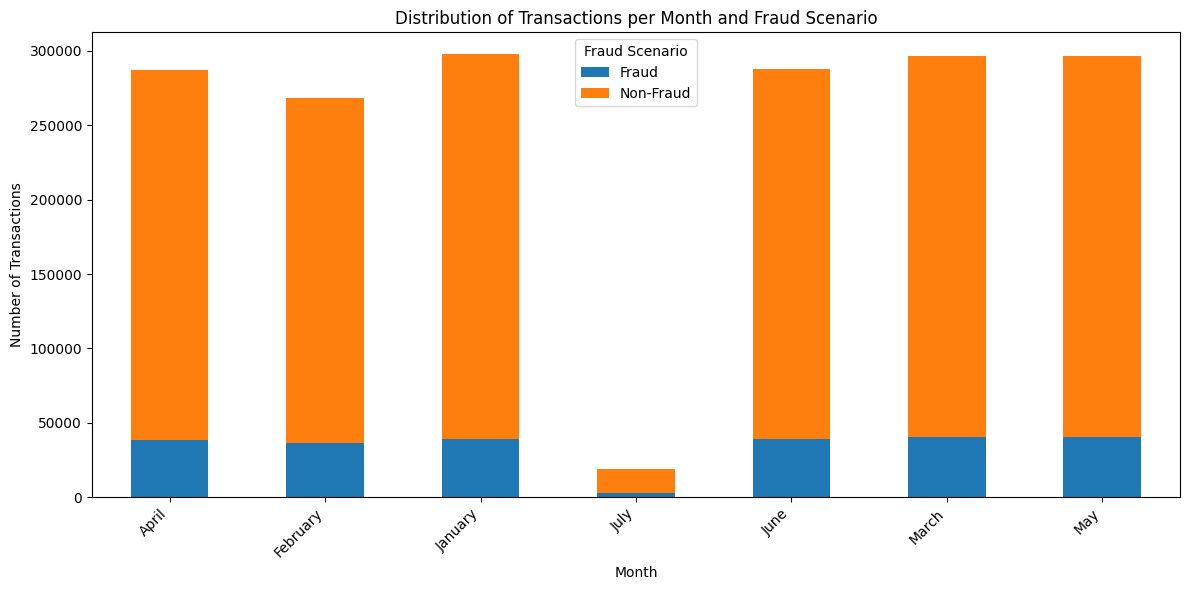

In [14]:
def visualize_monthly_transactions(df):
    """
    Visualizes the distribution of transactions per month and their fraud scenario using a grouped bar plot.

    :param df: DataFrame containing transaction data.
    """

    # Convert 'TX_DATETIME' column to datetime format
    df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

    # Extract month and fraud scenario from the transaction datetime
    df['TX_MONTH'] = df['TX_DATETIME'].dt.month_name()
    df['FRAUD'] = df['TX_FRAUD_SCENARIO'].apply(lambda x: 'Fraud' if 'FRAUD' in x.upper() else 'Non-Fraud')

    # Group by month and fraud scenario, and count the number of transactions
    grouped = df.groupby(['TX_MONTH', 'FRAUD']).size().unstack(fill_value=0)

    # Plot the grouped bar plot
    grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Distribution of Transactions per Month and Fraud Scenario')
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Fraud Scenario')
    plt.tight_layout()
    plt.show()

# Call the function to visualize monthly transactions and fraud scenarios
visualize_monthly_transactions(df)

In [15]:
df = df.drop(['TX_FRAUD_SCENARIO','TX_MONTH'], axis=1)
df['FRAUD'] = df['FRAUD'].apply(lambda x: 1 if x == 'Fraud' else 0)
total_entries = len(df)
num_fraud = (df['FRAUD'] == 1).sum()
percentage_fraud = (num_fraud / total_entries) * 100
print("Percentage of fraud cases:", percentage_fraud, "%")
df.head()

Percentage of fraud cases: 13.45200395632085 %


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,FRAUD
0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0
1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0
2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1
3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0
4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0


In [16]:
target_column = 'FRAUD'

# Exclude timestamp and ids columns from features
X = df.drop([target_column, 'TX_DATETIME', 'CUSTOMER_ID', 'TRANSACTION_ID'], axis=1)
y = df[target_column]

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)

balanced_df = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.DataFrame(y_balanced, columns=[target_column])], axis=1)

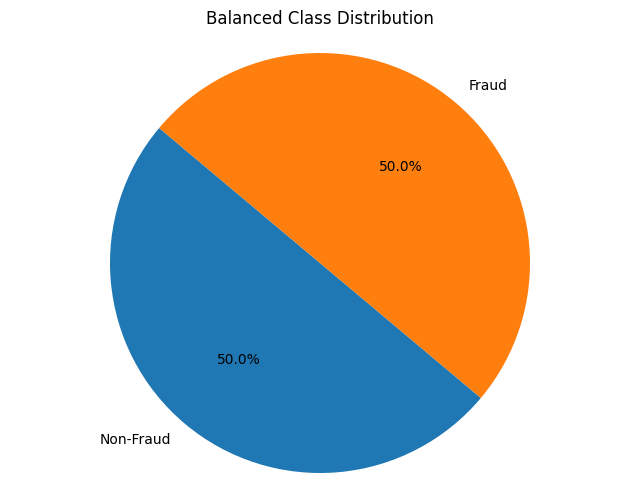

In [17]:
def plot_data_imbalance(data_frame, target_column):
    """
    Display a pie chart to illustrate the class imbalance in the target column.

    :param data_frame: The DataFrame containing the data.
    :param target_column: The name of the target column for which the imbalance should be illustrated.
    """
    # Map numerical labels to string labels
    label_mapping = {1: 'Fraud', 0: 'Non-Fraud'}
    data_frame[target_column] = data_frame[target_column].map(label_mapping)

    # Get value counts of target column
    fraud_counts = balanced_df['FRAUD'].value_counts()

    # Plot pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Balanced Class Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

# Call the function to display the class imbalance in the 'TX_FRAUD_SCENARIO' column
plot_data_imbalance(balanced_df, 'FRAUD')

In [18]:
# It's up to you to continue
# Remember to look in the module subject for more information on what to do next and on the benefits of this module, the following exercises are no longer guided.

# Sppliting data in training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training Data Class Distribution:")
print(y_train.value_counts())

print("\nTest Data Class Distribution:")
print(y_test.value_counts())

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training Data Class Distribution:
FRAUD
0    1063124
1     164784
Name: count, dtype: int64

Test Data Class Distribution:
FRAUD
0    455062
1     71185
Name: count, dtype: int64


In [19]:
# Multinomial logistic regression model

model = LogisticRegression(multi_class='multinomial')

# Train the model
model.fit(X_train_scaled, y_train)

LogisticRegression(multi_class='multinomial')

In [20]:
# Prediction on the training data

prediction = model.predict(X_train_scaled)

accuracy = accuracy_score(y_train, prediction)
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(y_train, prediction)

print("Confusion matrix on training data:")
print(conf_matrix)

Accuracy: 0.994027239825785
Confusion matrix on training data:
[[1063102      22]
 [   7312  157472]]


In [21]:
# Prediction on the test data

prediction = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, prediction)
print("Accuracy:", accuracy)
conf_matrix = confusion_matrix(y_test, prediction)

print("Confusion matrix on test data:")
print(conf_matrix)

Accuracy: 0.9940446216320473
Confusion matrix on test data:
[[455046     16]
 [  3118  68067]]


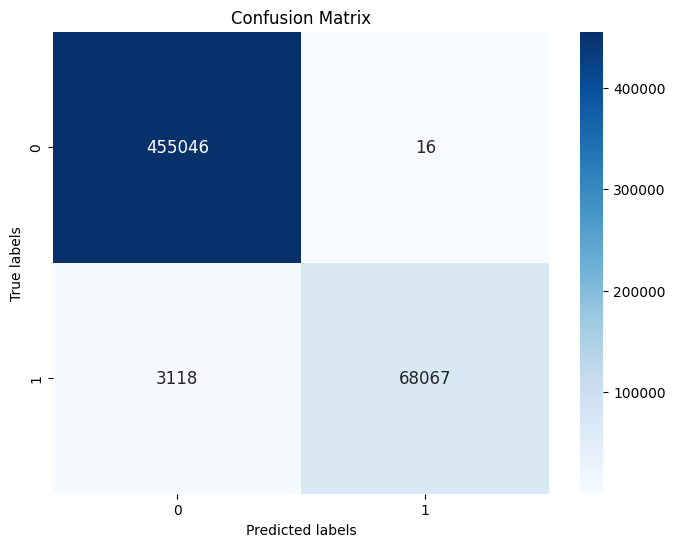

In [22]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, prediction)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 12})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# DECISION TREE

# Create a decision tree classifier
dtree = tree.DecisionTreeClassifier()

# Train the classifier
dtree = dtree.fit(X_train_scaled, y_train)
y_pred_dtree = dtree.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred_dtree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    455062
           1       1.00      1.00      1.00     71185

    accuracy                           1.00    526247
   macro avg       1.00      1.00      1.00    526247
weighted avg       1.00      1.00      1.00    526247



In [24]:
# xgboost

# Create an XGBoost classifier
dxgb = xgb.XGBClassifier()

# Train the classifier
dxgb = dxgb.fit(X_train_scaled, y_train)
y_pred_dxgb = dxgb.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred_dxgb))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    455062
           1       1.00      0.96      0.98     71185

    accuracy                           0.99    526247
   macro avg       1.00      0.98      0.99    526247
weighted avg       0.99      0.99      0.99    526247



In [25]:
# Random Forest accuracy

# Create an XGBoost classifier
rf = RandomForestClassifier()

# Train the classifier
rf = rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    455062
           1       1.00      0.97      0.99     71185

    accuracy                           1.00    526247
   macro avg       1.00      0.99      0.99    526247
weighted avg       1.00      1.00      1.00    526247



In [26]:
# xgb cross validation

# Define the pipeline
pipeline = Pipeline(steps=[('o', smote), ('m', dxgb)])

# Define the cross-validation strategy
rskfold = RepeatedStratifiedKFold(random_state=42)

# Evaluate the pipeline using cross-validation
scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=rskfold)

# Print the average score
print(scores)
print("Average Accuracy:", scores.mean())

[0.99295551 0.99347672 0.99315911 0.99264601 0.99335453 0.99303695
 0.99285778 0.99315096 0.99349298 0.99311022 0.99314689 0.99321612
 0.99278042 0.99296363 0.99295955 0.99280485 0.99337492 0.99298401
 0.99287811 0.99294327 0.99348894 0.99344822 0.99317947 0.99300842
 0.99298398 0.99315096 0.99329755 0.9928985  0.99311836 0.99306135
 0.99317947 0.99322019 0.99292701 0.99289033 0.99274781 0.99303695
 0.99282114 0.99275191 0.99333825 0.99332603 0.99302473 0.99314689
 0.99339935 0.99276817 0.99310614 0.9935378  0.99334642 0.99300845
 0.99284147 0.99315094]
Average Accuracy: 0.9930899545316472


In [28]:
# Select the best oversampling method and parameters based on the cross-validation results

best_oversampler = smote

# Oversample the training set using the best oversampling method and parameters
x_train_oversampled, y_train_oversampled = best_oversampler.fit_resample(X_train_scaled, y_train)

# Train your model on the oversampled training set
dxgb2 = pipeline.fit(x_train_oversampled, y_train_oversampled)

# Evaluate the performance of your model on the test set
y_pred_dxgb2 = dxgb2.predict(X_test_scaled)

#classification report
print(classification_report(y_test, y_pred_dxgb2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    455062
           1       0.99      0.96      0.98     71185

    accuracy                           0.99    526247
   macro avg       0.99      0.98      0.99    526247
weighted avg       0.99      0.99      0.99    526247

